In [1]:
import numpy as np
import os

data_path = '/home/yigit/Documents/projects/irl_sfm/data/demonstrations/sfm/continuous_poses_1/new/'
out_path = '/home/yigit/Documents/projects/cnmp/data/sfm/continuous_poses_1/new/combined_1/'

try:
    os.mkdir(out_path)
except:
  pass
try:
    os.mkdir(f'{out_path}demonstrations')
except:
  pass
try:
    os.mkdir(f'{out_path}novel')
except:
  pass

demonstrations = []

for filename in os.listdir(data_path):
    if filename.endswith(".npy"):
        path = os.path.join(data_path, filename)
        demonstrations.append(np.load(path, allow_pickle=True, encoding='latin1'))
#         print(f'{len(demonstrations)-1}: {path}')

num_demos = len(demonstrations)

In [2]:
print(num_demos)

15839


In [3]:
from tqdm import tqdm

desired_len = 400 # min_len
x_dim, gamma_dim, y_dim, pose_dim = 2, 2, 2, 2
vx_jump_threshold, vy_jump_threshold = 0.4, 0.4


ldx, ldy, ldg, lp = [], [], [], []


thrown = 0

for i, demo in enumerate(tqdm(demonstrations, desc="Processing")):
    len_demo = len(demo)
    
    indices = np.linspace(15, len_demo-5, desired_len, dtype=int)  # <desired_len>-many indices are selected uniformly
    x, gmm, y, poses = np.zeros((desired_len, x_dim)), np.zeros((desired_len, gamma_dim)), np.zeros((desired_len, y_dim)), np.zeros((desired_len, pose_dim))
    
    discard = False
    for new_ind, old_ind in enumerate(indices):
        x[new_ind] = demo[old_ind][:x_dim]
        gmm[new_ind] = demo[old_ind][x_dim:x_dim+gamma_dim]
        y[new_ind] = demo[old_ind][x_dim+gamma_dim:x_dim+gamma_dim+y_dim]
        poses[new_ind] = demo[old_ind][x_dim+gamma_dim+y_dim:x_dim+gamma_dim+y_dim+pose_dim]
        
        if new_ind > 0 and \
        ((y[new_ind][0]-y[new_ind-1][0])>vx_jump_threshold or (y[new_ind][1]-y[new_ind-1][1])>vy_jump_threshold):
            discard = True
            thrown+=1
            break

    if not discard:
        ldx.append(x)
        ldy.append(y)
        ldg.append(gmm)
        lp.append(poses)


print(f'Thrown: {thrown}')
num_demos = len(ldx)
print(f'Left: {num_demos}')

d_X = np.zeros((num_demos, desired_len, x_dim))
d_Gamma =  np.zeros((num_demos, desired_len, gamma_dim))
d_Y = np.zeros((num_demos, desired_len, y_dim))
d_p = np.zeros((num_demos, desired_len, pose_dim))

for i in tqdm(range(num_demos), desc="Copying"):
    d_X[i] = ldx[i]
    d_Gamma[i] = ldg[i]
    d_Y[i] = ldy[i]
    d_p[i] = lp[i]

#############
# novel cases
#############

num_novel = 3

n_X = np.zeros((num_novel, desired_len, x_dim))
n_Gamma =  np.zeros((num_novel, desired_len, gamma_dim))
n_Y = np.zeros((num_novel, desired_len, y_dim))

for i in range(num_novel):
    rand_ind = np.random.randint(0, len(d_X))
    
    n_X[i] = d_X[rand_ind]
    n_Gamma[i] = d_Gamma[rand_ind]
    n_Y[i] = d_Y[rand_ind]

    d_X = np.delete(d_X, rand_ind, 0)
    d_Gamma = np.delete(d_Gamma, rand_ind, 0)
    d_Y = np.delete(d_Y, rand_ind, 0)
    
num_demos = len(d_X)
print(num_demos)

Copying: 100%|██████████| 3581/3581 [00:00<00:00, 55609.13it/s]


Thrown: 12258
Left: 3581
3578


<IPython.core.display.Javascript object>


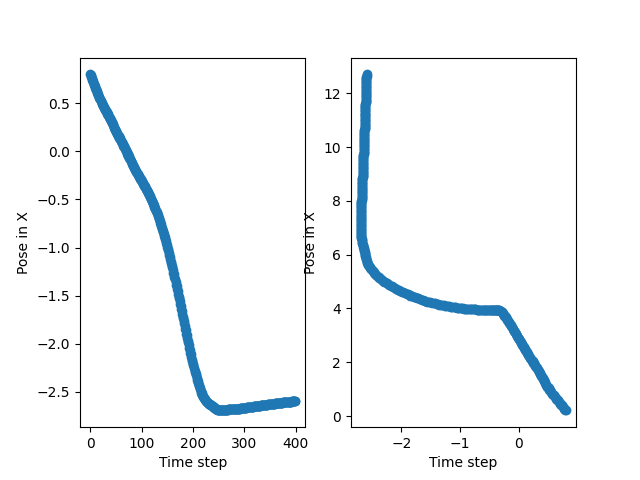

<IPython.core.display.Javascript object>


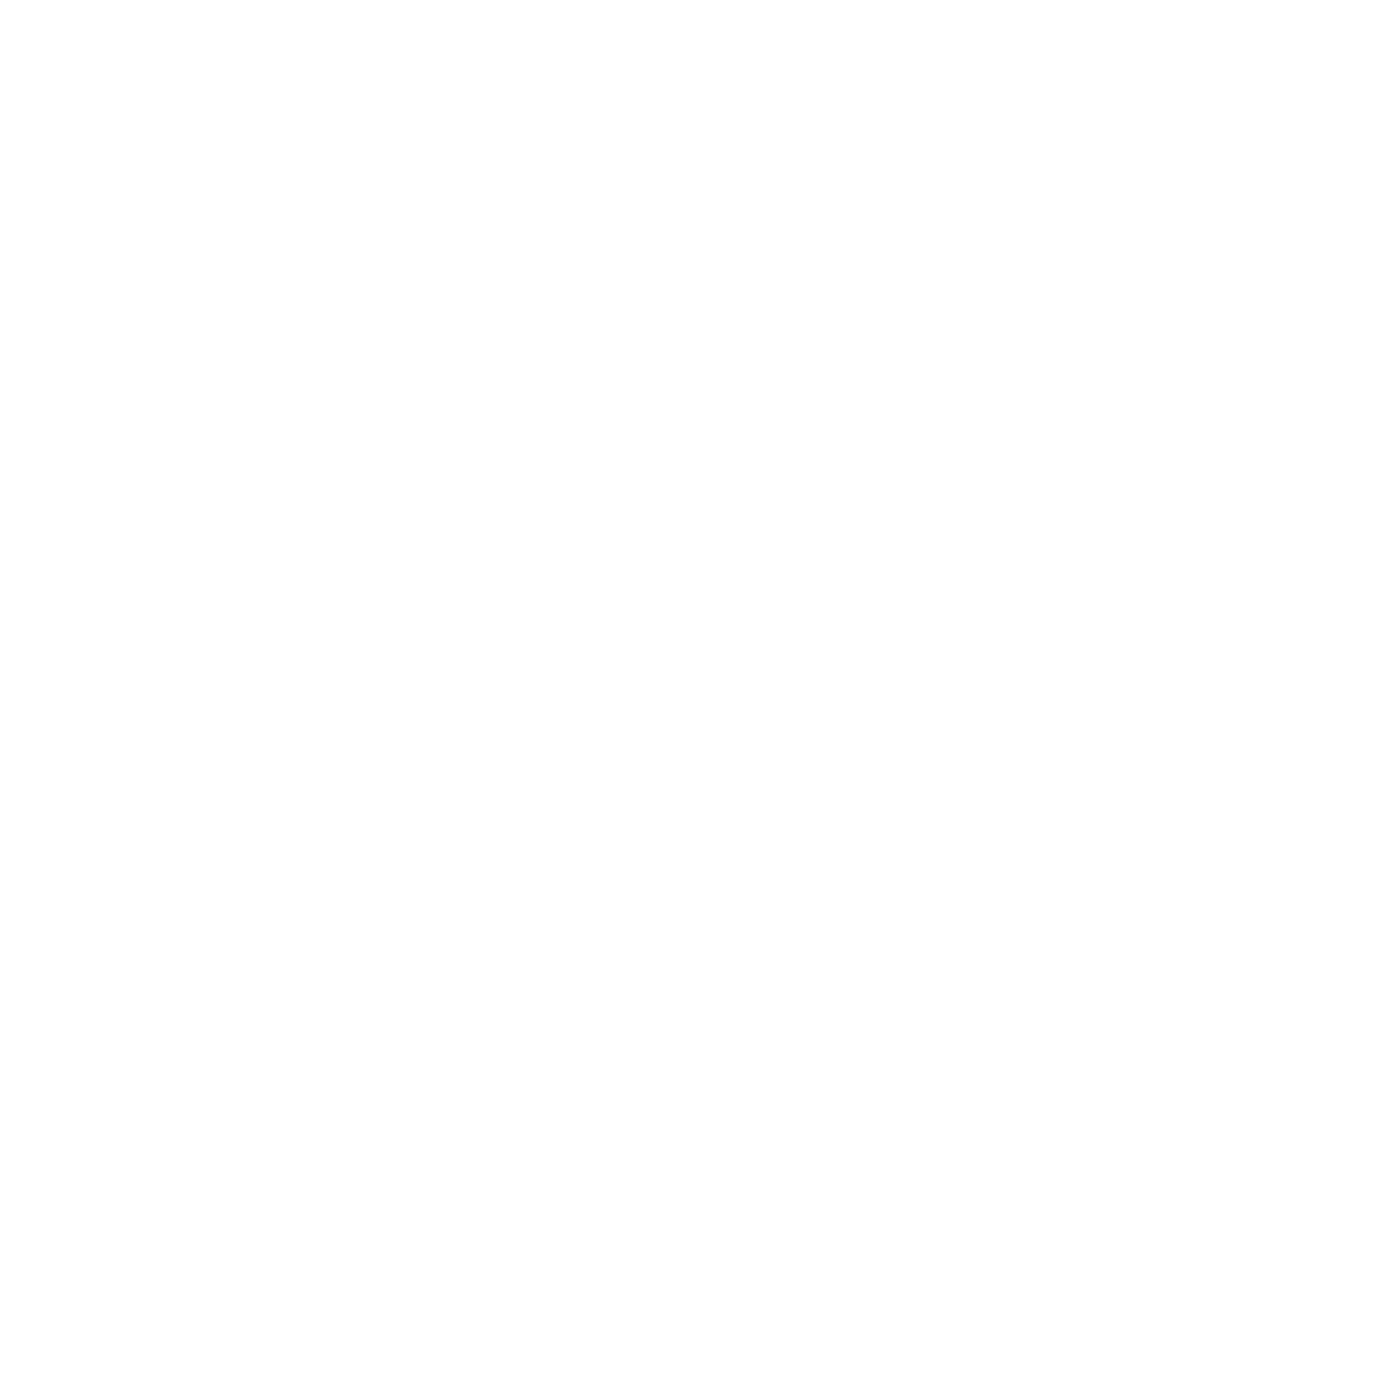

[Text(0.5, 0, 'Time step'), Text(0, 0.5, 'Pose in X')]

In [26]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2)
fig = plt.figure(figsize=(14,14))
for i in range(7,8):
    axs[0].scatter(range(len(d_p[i])), d_p[i][:, 0])  # v_x
# axs[0].set_title('v_x values')
axs[0].set(xlabel='Time step', ylabel='Pose in X')

for i in range(7,8):
    axs[1].scatter(d_p[i][:, 0], d_p[i][:, 1])  # v_x
# axs[1].set_title('Velocity')
axs[1].set(xlabel='Time step', ylabel='Pose in Y')
# plt.plot(range(len(d_p[i])), d_p[i][:, 0])
# plt.xlabel('time step')
# plt.ylabel('x_pose')

<IPython.core.display.Javascript object>


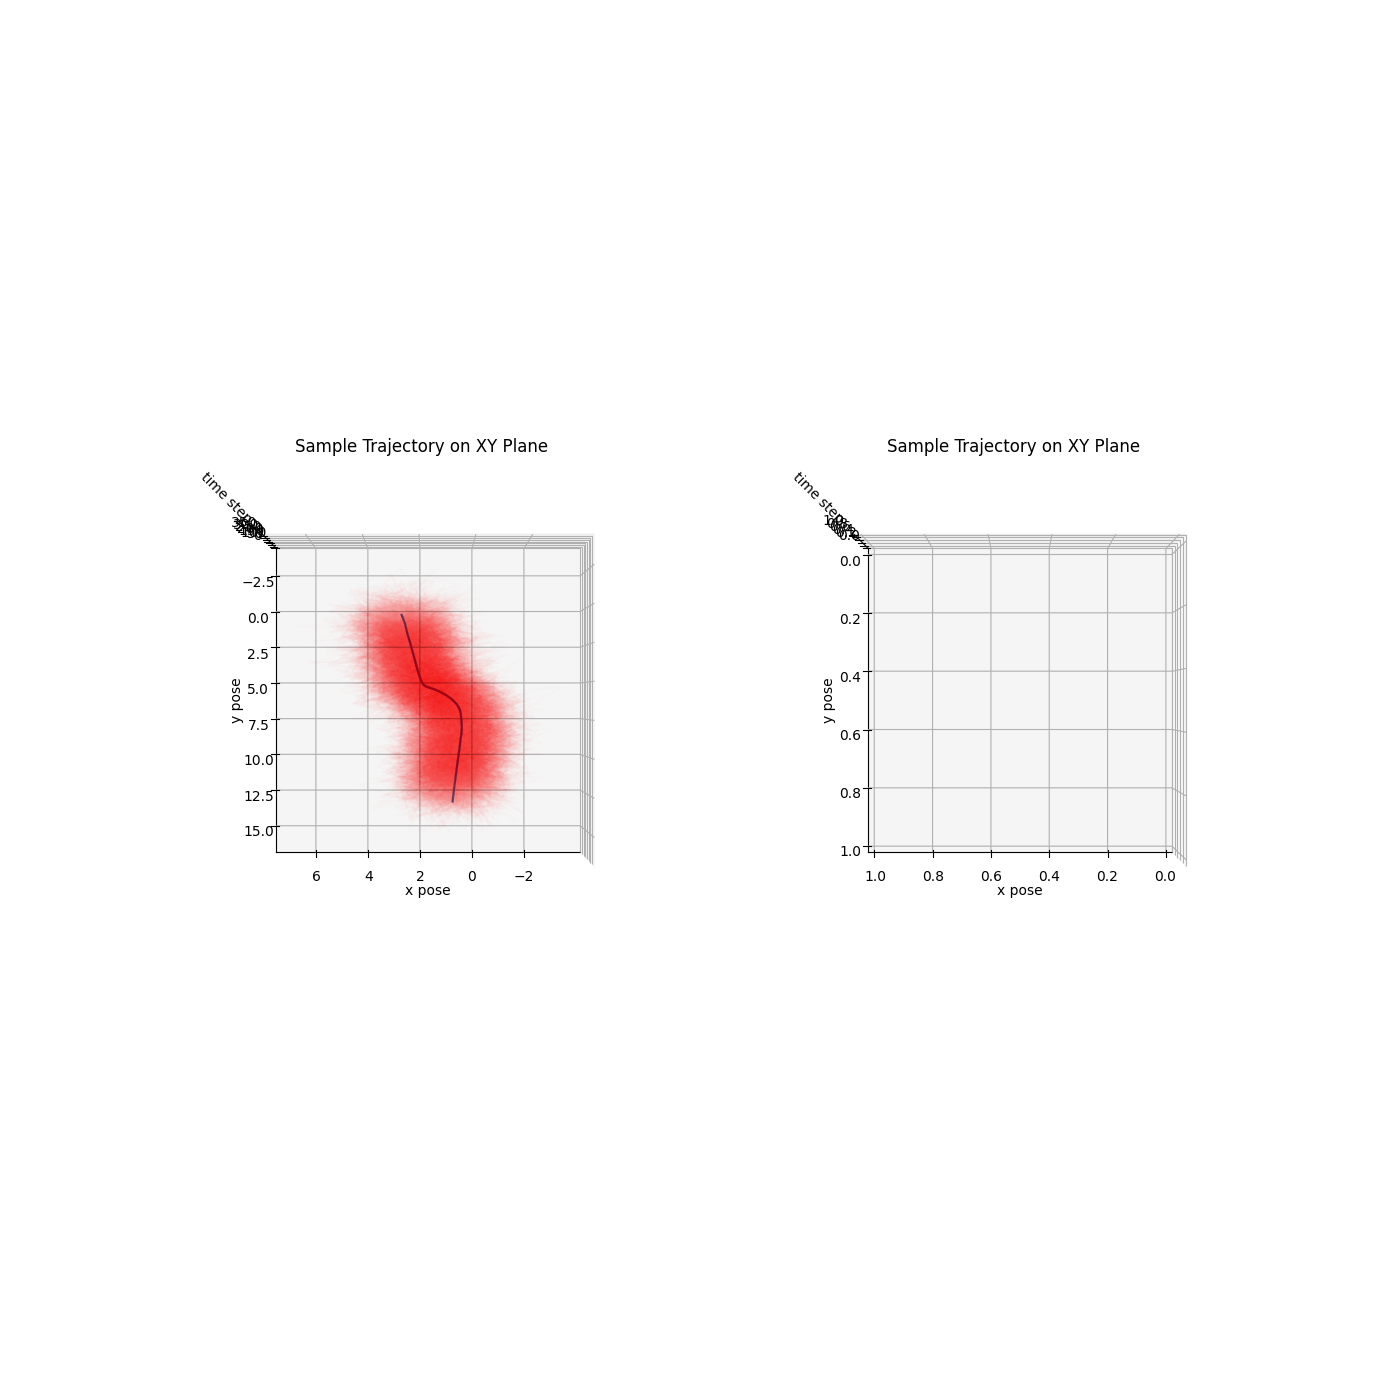

In [45]:
%matplotlib notebook

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14,14))
ax0 = fig.add_subplot(121, projection='3d')
ax0.set(xlabel='x pose', ylabel='y pose', zlabel='time step')
ax0.set_title("Sample Trajectory on XY Plane")
ax0.plot(d_p[0][:, 0], d_p[0][:, 1], range(len(d_p[i])))
for i in range(len(d_p[i])):
    x, y = np.random.multivariate_normal((d_p[0][i, 0], d_p[0][i, 1]), [[1, 0], [0, 1]], 100).T
    ax0.plot(x,y,'r-',alpha=0.01)
ax0.view_init(90, 90)


ax1 = fig.add_subplot(122, projection='3d')
ax1.set(xlabel='x pose', ylabel='y pose', zlabel='time step')
ax1.set_title("Sample Trajectory on XY Plane")
# ax0.plot(d_p[0][:, 0], d_p[0][:, 1], range(len(d_p[i])))
# for i in range(len(d_p[i])):
#     x, y = np.random.multivariate_normal((d_p[0][i, 0], d_p[0][i, 1]), [[1, 0], [0, 1]], 100).T
#     ax0.plot(x,y,'r-',alpha=0.01)
ax1.view_init(90, 90)

# ax1 = fig.add_subplot(122, projection='3d')
# ax1.set(xlabel='x pose', ylabel='y pose', zlabel='time step')
# ax1.set_title("Sample Trajectory Discretized Points")
# ax1.scatter(d_p[0][:, 0], d_p[0][:, 1], range(len(d_p[i])))

plt.show()

# for angle in range(0, 360):
#     ax.view_init(30, angle)
#     plt.draw()
#     plt.pause(.001)

# fig, axs = plt.subplots(2, 2)
# for i in range(6):
#     axs[0, 0].plot(range(len(d_p[i])), d_p[i][:, 0])  # v_x
# axs[0, 0].set_title('v_x values')
# axs[0, 0].set(xlabel='step', ylabel='speed')

# for i in range(6,7):
#     axs[0, 1].plot(d_p[i][:, 0], d_p[i][:, 1])  # v_x
# axs[0, 1].set_title('v_y values')
# axs[0, 1].set(xlabel='step', ylabel='speed')

In [5]:
print(len(d_Y))

3575


In [ ]:
num_val = 331  # 331 out of 3531 

x_train, x_val, y_train, y_val, gamma_train, gamma_val = [], [], [], [], [], []
val_indices = np.sort(np.random.choice(range(num_demos-1), num_val, replace=False))

for i in range(num_demos):
    if i in val_indices:  # validation instance
#         print(f'val: {i}')
        x_val.append(d_X[i])
        gamma_val.append(d_Gamma[i])
        y_val.append(d_Y[i])
    else:  # training instance
        x_train.append(d_X[i])
        gamma_train.append(d_Gamma[i])
        y_train.append(d_Y[i])
        
np.save(out_path + 'demonstrations/' + 'd_x.npy', np.array(x_train))
np.save(out_path + 'demonstrations/' + 'd_y.npy', np.array(y_train))
np.save(out_path + 'demonstrations/' + 'd_gamma.npy', np.array(gamma_train))
np.save(out_path + 'demonstrations/' + 'v_d_x.npy', np.array(x_val))
np.save(out_path + 'demonstrations/' + 'v_d_y.npy', np.array(y_val))
np.save(out_path + 'demonstrations/' + 'v_d_gamma.npy', np.array(gamma_val))

#############
# novel case
#############

np.save(out_path + 'novel/' + 'd_x.npy', np.array(n_X))
np.save(out_path + 'novel/' + 'd_y.npy', np.array(n_Y))
np.save(out_path + 'novel/' + 'd_gamma.npy', np.array(n_Gamma))